In [114]:
import pandas as pd

import numpy as np
import pandas as pd

from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

import matplotlib.pyplot as plt
import timesfm

import warnings
warnings.filterwarnings('ignore')

In [115]:
dfColumns = ['date','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']
DAYS = 5
TEST_BEGIN = '2021.04.06'
TEST_END = '2021.06.01'
TRAIN_BEGIN = '2018.03.30'
TRAIN_END = '2021.04.05'
TIMES = 10

In [116]:
def create_df(fundo):
    df = pd.read_csv(f'../Data/{fundo}_Daily.csv', sep = "\t")
    df.columns = dfColumns
    df = removeColumns(df, ['tickvol', 'volume','spread'])
    df = calculateEMA(df,DAYS,newColumns)
    df = calculateBB(df,DAYS,newColumns)
    df = addPreviousDays(df,DAYS, newColumns)
    initialDf_ = getPeriod(df, '2017.06.01','2021.06.01', True)
    return initialDf_

In [131]:
def adjustDf(df, target_col):
    # 1. Copiar apenas as colunas relevantes
    df_model = df[['date', target_col]].copy()

    # 2. Renomear as colunas como esperado
    df_model.columns = ['ds', 'y']

    # 3. Adicionar coluna de ID da série (TimesFM espera isso)
    df_model['unique_id'] = 'ABEV3'

    # 4. Garantir que a coluna de data esteja no formato datetime
    df_model['ds'] = pd.to_datetime(df_model['ds'])

    # 5. Reorganizar as colunas na ordem correta
    df_model = df_model[['unique_id', 'ds', 'y']]
    return df_model


In [133]:
def exp_timesFm(df, target_col='open', normalizer='', 
                train_start='2018.04.02', train_end='2021.02.03',
                valid_start='2021.02.04', valid_end='2021.04.05',
                test_start='2021.04.06', test_end='2021.06.01',
                prediction_length=5):

    # 1. Separar os períodos
    df_train = getPeriod(df, train_start, valid_end)
    df_test  = getPeriod(df, test_start, test_end)

    y_test  = df_test[target_col].values

    # 3. Preparar entrada para Chronos
    tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=prediction_length,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-1.0-200m-pytorch"),
    )

    forecast_df = tfm.forecast_on_df(
        inputs=adjustDf(df_train, target_col),   # DataFrame com colunas: unique_id, ds, y
        freq="B",
        value_name='y'
    )

    y_pred_mean = forecast_df['timesfm-q-0.5']
    y_test_orig = y_test[-prediction_length:]
    q10 = forecast_df['timesfm-q-0.1']
    q90 = forecast_df['timesfm-q-0.9']
    uncertainty = q90 - q10
    date = forecast_df['ds']

    return [y_test_orig, y_pred_mean, uncertainty, date]


In [134]:
def runPrediction(fundo):
    df = create_df(fundo)

    orig_high, pred_high, uncertainty_high, date_high = exp_timesFm(df, prediction_length=41, target_col='high')
    pred_high = pred_high.drop(pred_high.index[11])
    uncertainty_high = uncertainty_high.drop(uncertainty_high.index[11])

    orig_low, pred_low, uncertainty_low, date_high = exp_timesFm(df, prediction_length=41, target_col='low')
    pred_low = pred_low.drop(pred_low.index[11])
    uncertainty_low = uncertainty_low.drop(uncertainty_low.index[11])

    date = date_high.drop(date_high.index[11])

    return [orig_high, pred_high, uncertainty_high, orig_low, pred_low, uncertainty_low, date]
    

In [135]:
def generatePlot(y_test_orig, y_pred_mean, uncertainty, target_col, fundo): 

    # Criar eixo de tempo
    dias = np.arange(len(y_test_orig))

    # Calcular faixa de incerteza (intervalo 90% - 10%)
    inferior = y_pred_mean - (uncertainty / 2)
    superior = y_pred_mean + (uncertainty / 2)

    plt.figure(figsize=(10, 6))

    # Linha real (azul)
    plt.plot(dias, y_test_orig, label='Valor Real', color='blue', marker='o')

    # Linha prevista (laranja)
    plt.plot(dias, y_pred_mean, label='Previsão Média', color='red', marker='o')

    # Faixa de incerteza (sombreada)
    plt.fill_between(dias, inferior, superior, color='orange', alpha=0.3, label='Incerteza (10%-90%)')

    # Rótulos e legendas
    plt.title(f'Previsão com TimesFm vs Valor Real {fundo}')
    plt.xlabel('Dias')
    plt.ylabel('Preço (' + target_col + ')')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [136]:
df = pd.read_csv('../Data/PETR4_Daily.csv', sep = "\t")
df.columns = dfColumns
df = removeColumns(df, ['tickvol', 'volume','spread'])

df 
df.tail(290)

,date,open,high,low,close
1049,2020.03.31,13.16,14.07,13.16,13.54
1050,2020.04.01,13.01,14.08,12.89,13.84
1051,2020.04.02,14.90,16.01,14.52,15.01
1052,2020.04.03,15.77,15.83,14.44,14.84
1053,2020.04.06,15.53,15.58,14.69,15.26
...,...,...,...,...,...
1334,2021.05.26,25.91,26.18,25.65,26.09
1335,2021.05.27,26.08,26.25,25.77,25.91
1336,2021.05.28,26.20,27.02,26.15,26.99
1337,2021.05.31,26.96,27.20,26.78,26.87


Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


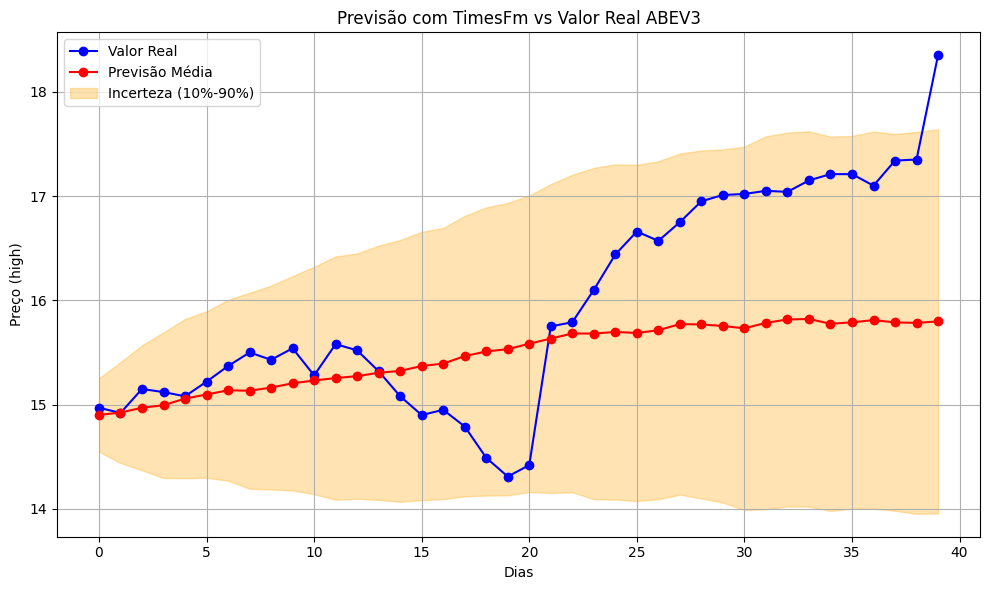

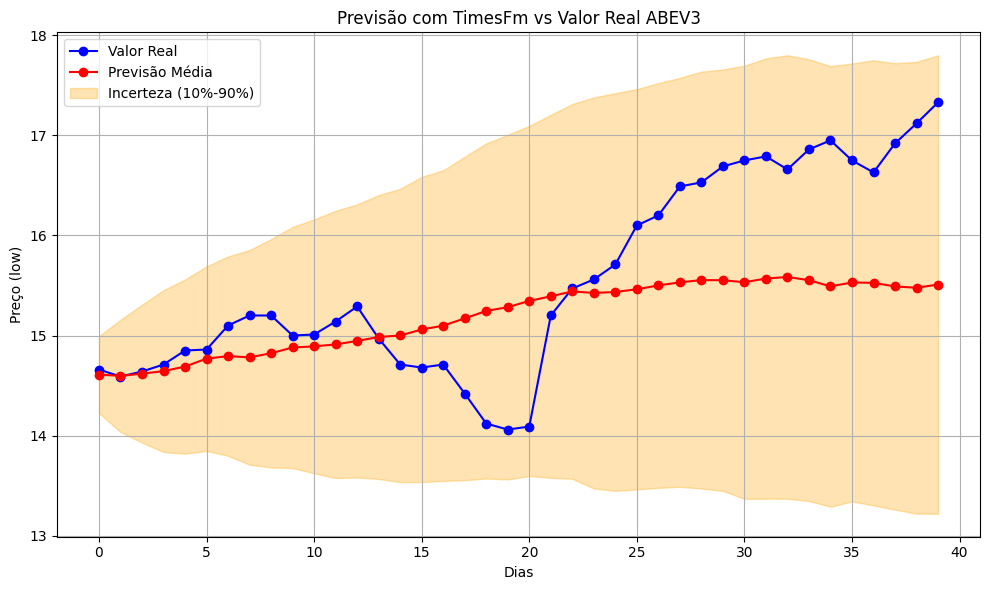

Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


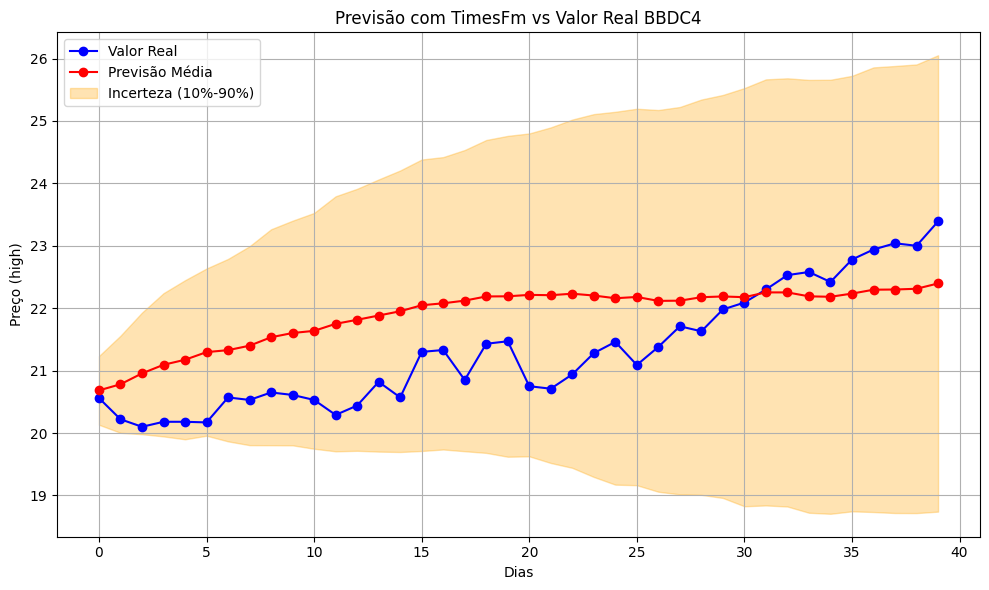

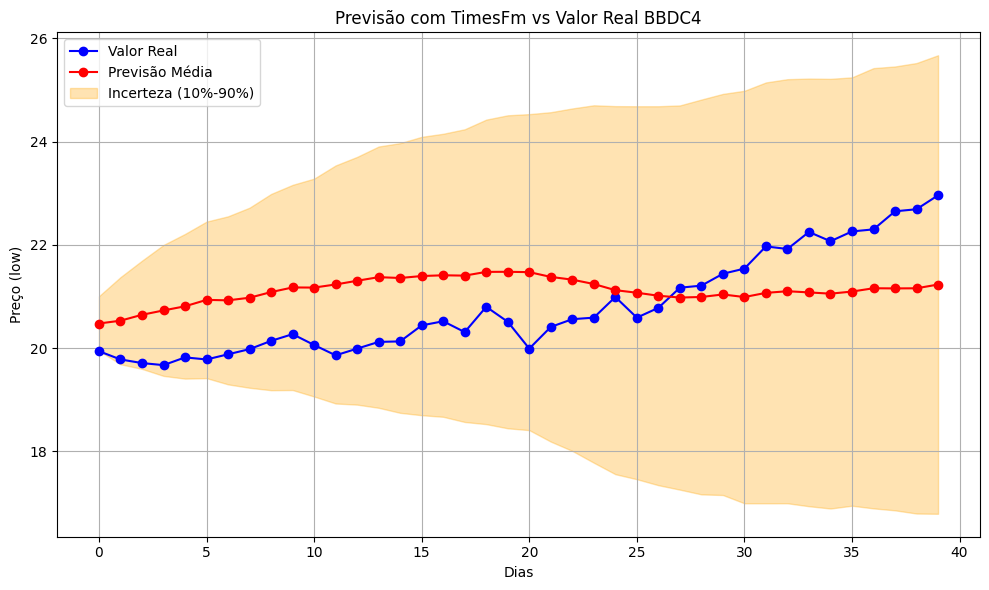

Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


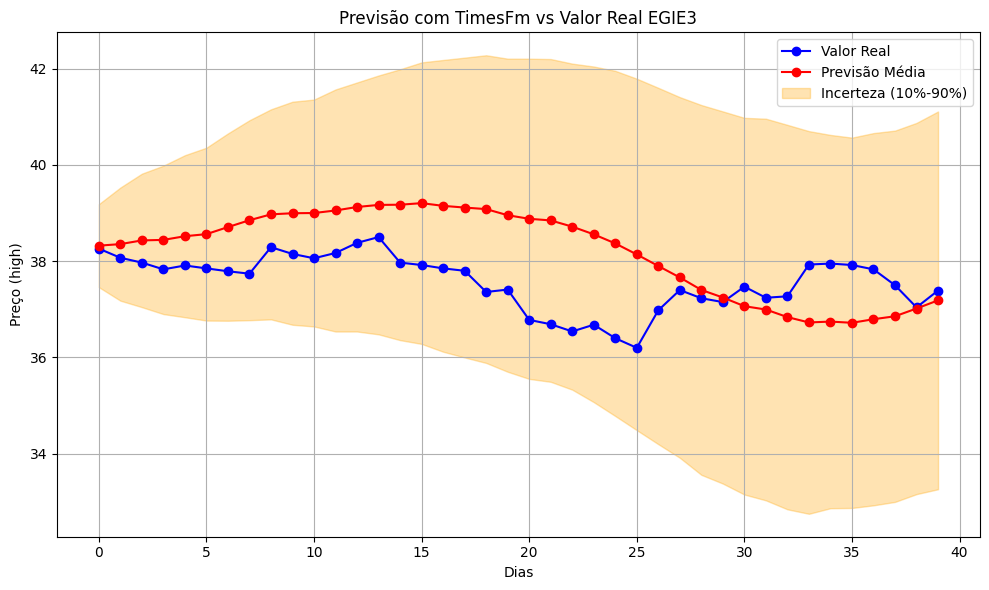

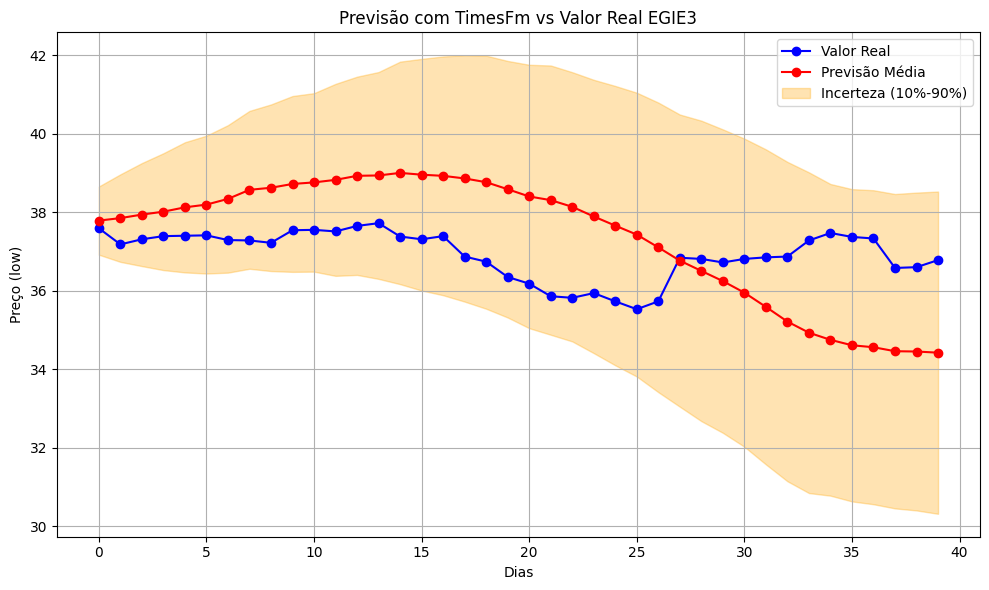

Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


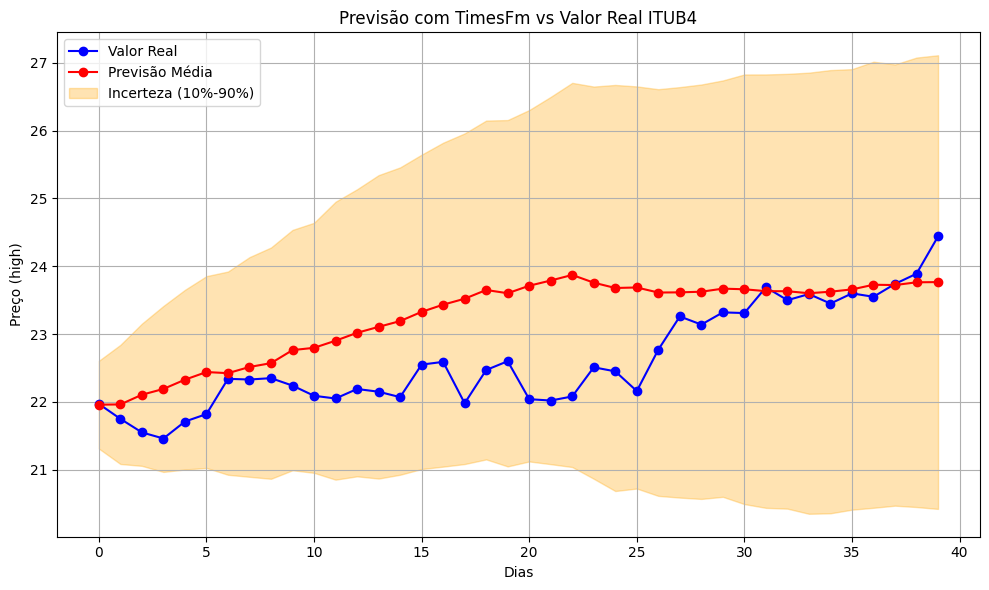

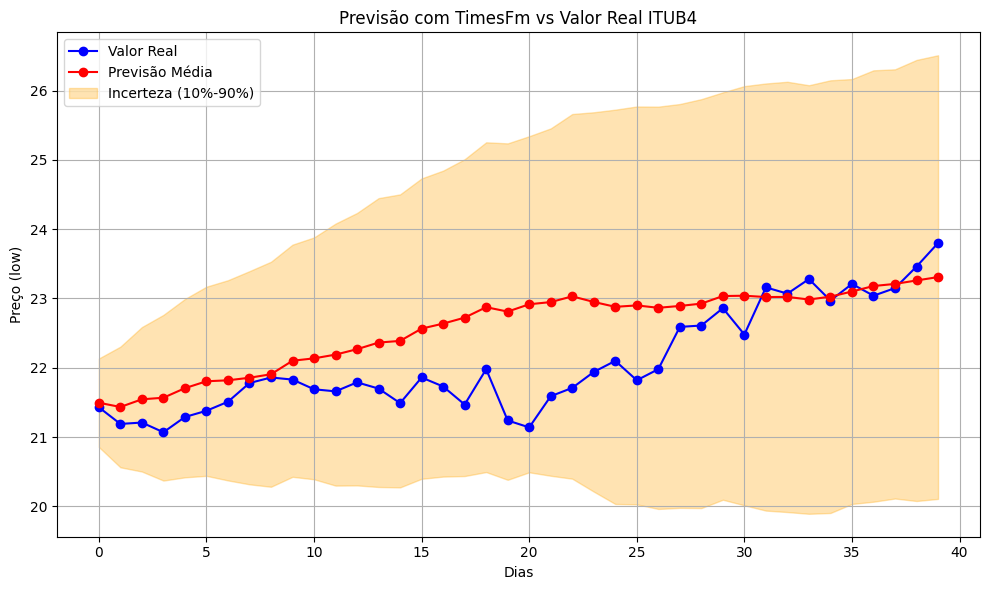

Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


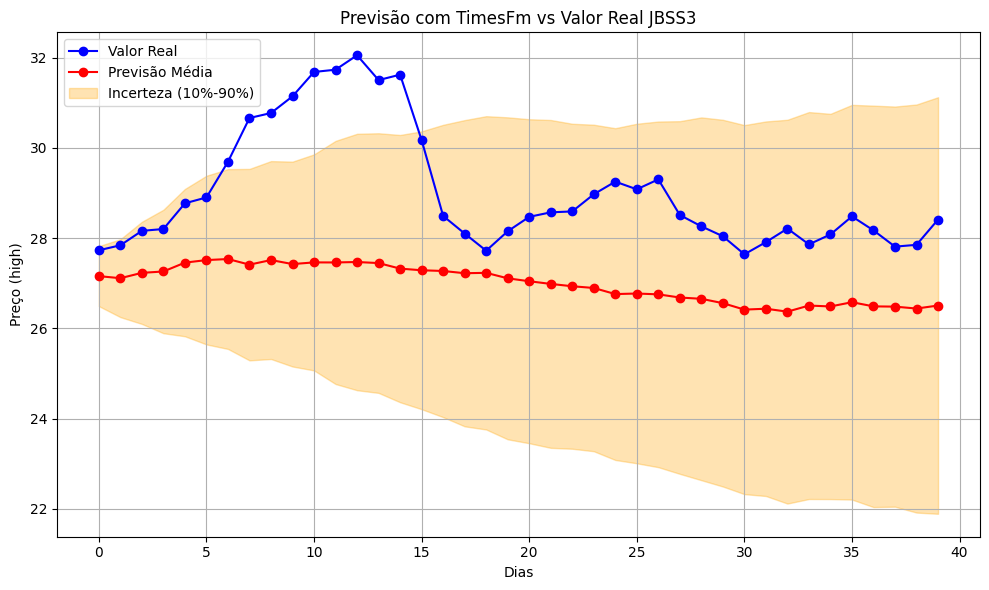

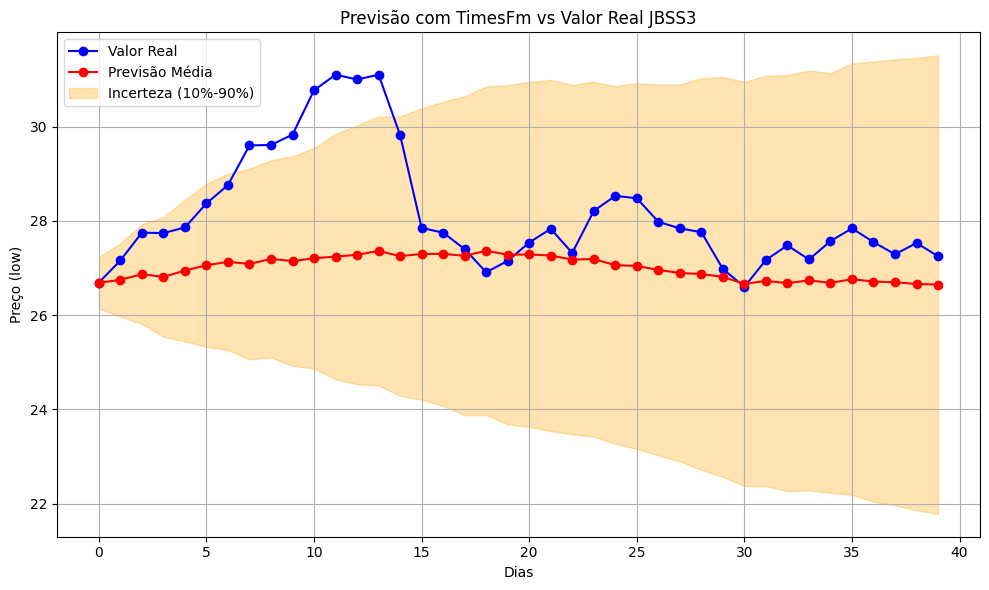

Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


Fetching 3 files: 100%|██████████| 3/3 [00:00<?, ?it/s]


Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


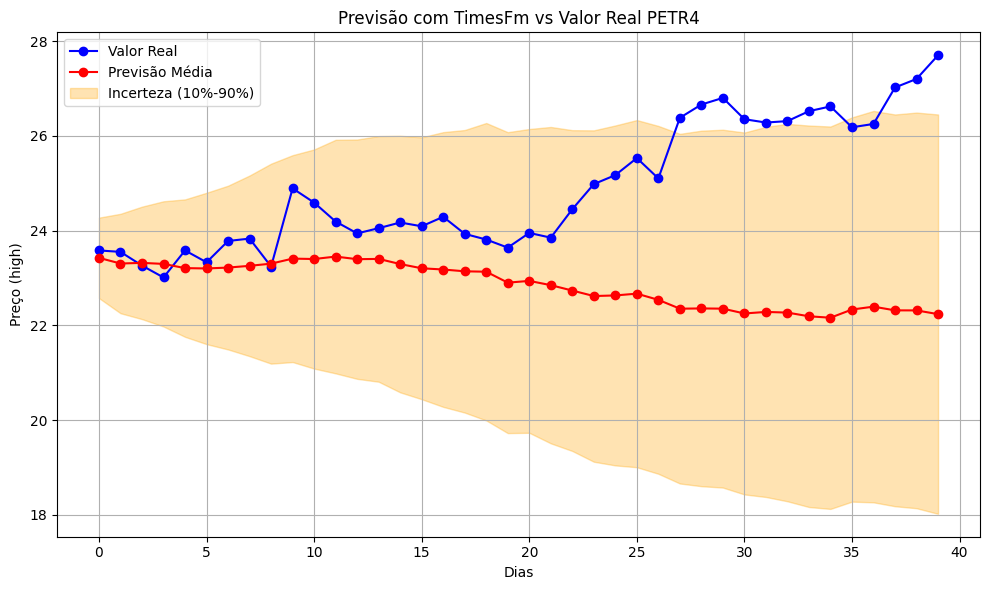

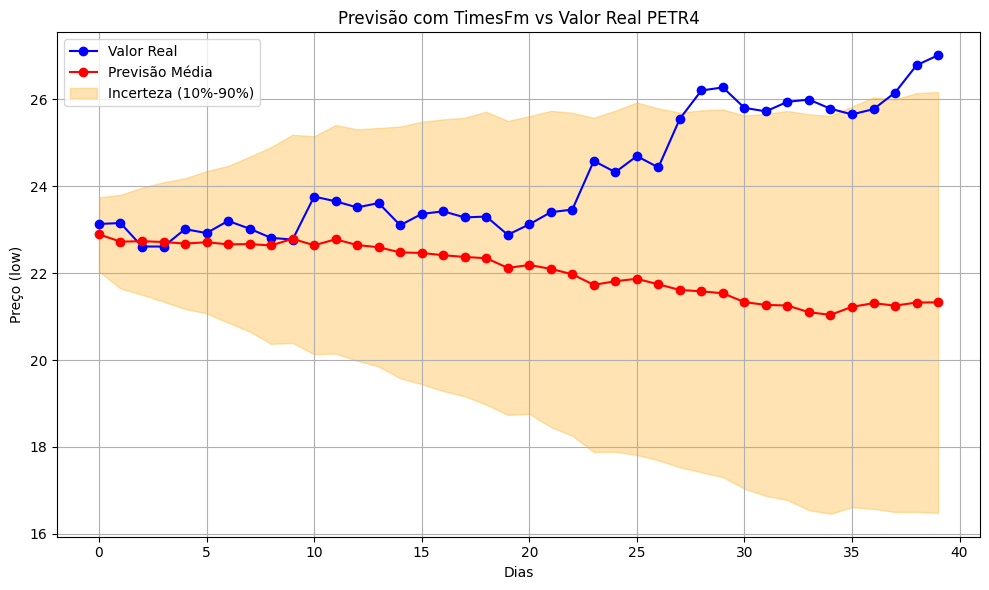

In [138]:
fundos = ['ABEV3', 'BBDC4', 'EGIE3', 'ITUB4', 'JBSS3', 'PETR4']
for name in fundos:
    orig_high, pred_high, uncertainty_high, orig_low, pred_low, uncertainty_low, date = runPrediction(name)

    generatePlot(orig_high, pred_high, uncertainty_high, 'high', name)
    generatePlot(orig_low, pred_low, uncertainty_low, 'low', name)
    
    result_prediction = pd.DataFrame()
    result_prediction['date'] = date.dt.strftime('%Y.%m.%d')
    result_prediction['high_pred'] = pred_high
    result_prediction['low_pred'] = pred_low
    result_prediction['uncertainty_high'] = uncertainty_high
    result_prediction['uncertainty_low'] = uncertainty_low
    result_prediction['uncertainty_mean'] = (result_prediction['uncertainty_high'] + result_prediction['uncertainty_low']) / 2
    result_prediction['high'] = orig_high
    result_prediction['low'] = orig_low
    
    result_prediction.to_pickle(f'../Data/{name}_Pred_No_Finetuning_timesFm.pkl')



Você está dizendo:

Me mostre, para os próximos 5 dias:

O valor mais pessimista (quantil 0.1)

O valor mais provável (mediana, quantil 0.5)

O valor mais otimista (quantil 0.9)

📊 Exemplo numérico (dia 1)
Quantil	Valor	Interpretação
0.1	    23.1	10% das previsões ficam abaixo de 23.1 → valor conservador
0.5	    24.0	Previsão mais provável (mediana)
0.9	    25.4	90% das previsões ficam abaixo de 25.4 → valor otimista


In [139]:
pred = pd.read_pickle(f'../Data/ABEV3_Pred_No_Finetuning_timesFm.pkl')
pred

,date,high_pred,low_pred,uncertainty_high,uncertainty_low,uncertainty_mean,high,low
0,2021.04.06,14.900758,14.609432,0.706306,0.768431,0.737368,14.97,14.66
1,2021.04.07,14.924026,14.596393,0.966920,1.122314,1.044617,14.92,14.59
2,2021.04.08,14.969806,14.618669,1.198968,1.378572,1.288770,15.15,14.64
3,2021.04.09,14.994258,14.643899,1.395821,1.618235,1.507028,15.12,14.71
4,2021.04.12,15.057698,14.689721,1.526997,1.741243,1.634120,15.08,14.85
5,2021.04.13,15.096892,14.768850,1.596034,1.844957,1.720496,15.22,14.86
6,2021.04.14,15.137456,14.793928,1.733564,1.993064,1.863314,15.37,15.10
7,2021.04.15,15.133198,14.781493,1.879110,2.146203,2.012657,15.50,15.20
8,2021.04.16,15.163157,14.822870,1.954106,2.282699,2.118402,15.43,15.20
9,2021.04.19,15.204689,14.880219,2.055777,2.411075,2.233426,15.54,15.00
